<center> <b> <font size="3"> <font color="green">rfborg </font> :
    your detector technology will be assimilated— resistance is futile! </font> </b> </center> 

In [1]:
import os
import time
import casperfpga
import struct
from time import sleep
from matplotlib import pyplot as plt
import numpy as np
import ipywidgets as ipw
from ipywidgets import interact, interactive, fixed, interact_manual
#from scipy import signal
#import valon_synth9 as Valon
print("casperfpga version: %s" % casperfpga.__version__)

casperfpga version: 0.4.4.dev1039+rfsoc.8a917ae


In [124]:
FPG = "/home/jackh/src/umanc/souk/blast_module_casperize/outputs/blast_module_casperize_2022-05-09_1213.fpg"
ZCU111_HOST = "zcu111"
LMKFILE = "122M88_PL_122M88_SYSREF_7M68_clk5_12M8.txt"
LMXFILE = "LMX_REF_122M88_OUT_245M76.txt"
ADC_SAMPLE_RATE_MHZ = 3932.16
ADC_DECIMATION = 8
NFFT_BITS = 10
NFFT = 2**NFFT_BITS

In [125]:
# FIRMWARE UPLOAD
fpga = casperfpga.CasperFpga(ZCU111_HOST, transport=casperfpga.KatcpTransport)
print("FPGA at %s is connected?" % ZCU111_HOST, fpga.is_connected())


FPGA at zcu111 is connected? True


In [126]:
print("Programming FPGA with %s" % FPG)
fpga.upload_to_ram_and_program(FPG)
rfdc = fpga.adcs['rfdc']
rfdc.init(lmk_file=LMKFILE, lmx_file=LMXFILE)
rfdc.init()

Programming FPGA with /home/jackh/src/umanc/souk/blast_module_casperize/outputs/blast_module_casperize_2022-05-09_1213.fpg


True

In [127]:
print(fpga.estimate_fpga_clock())
rfdc.status()

246.2667955
ADC0: Enabled 1, State: 15 PLL: 1
ADC1: Enabled 0
ADC2: Enabled 0
ADC3: Enabled 0
DAC0: Enabled 0
DAC1: Enabled 1, State: 15 PLL: 1
DAC2: Enabled 0
DAC3: Enabled 0


True

In [128]:
fpga.write_int('adc_dac_loopback', 1) # Use internal DAC->ADC loopback (doesn't need any cabling)

# Generating DDS/DAC Waveform

In [199]:
# class rfsocInterface:
#     """
#     Set of functions running on the RFSoC to generate/capture/demodulate waveforms by interfacing with 
#     AXI registers and Block-Memory (BRAM) programmed in the firmware. 
#     """
ADDR_SIZE = 17
def norm_wave(ts, max_amp=2**15-1):
    """
     Re-scale generated data values to fit LUT
    """
    norm = max(abs(ts)) # abs to get magnitude of complex vector
    dacI = ((ts.real/norm)*max_amp).astype("int16")
    dacQ = ((ts.imag/norm)*max_amp).astype("int16")
    return dacI, dacQ

def surfsUpDude(freq_list, vna = False, verbose=False):
    """
    surfsUpDude Takes a list of specified frequencies and generates....stuff and things, then 
    uploads to the bram. Then we'll have totally ripped waves bruh, schralping the gnar.
    
    params
        freqlist: np.array
            list of tones to generate
        verbose: bool
            enable / disable printing (and or) plotting of data
    """
    #####################################################
    # HARDCODED LUT PARAMS
    #####################################################
    addr_size=ADDR_SIZE   # address bit width
    channels= 2           # data points per memory address for DAC
    fs = ADC_SAMPLE_RATE_MHZ * 1e6  # sampling rate of D/A, FPGA fabric = fs/2
    C  = ADC_DECIMATION              # decimation factor
    data_p = channels*2**(addr_size) # length of timestream or length of LUT+1
    
    #####################################################
    #  SET FREQ for LUT
    #####################################################
    if vna:
      N = 1000 # number of tones to make
      freqs = C*np.linspace(-250.0e6, 250.0e6,N) # equally spaced tones
    else:
      #freqs = -1*C*freq_list # equally spaced tones
      freqs = freq_list
    #phases = np.random.uniform(-np.pi,np.pi,len(freqs))
    np.random.seed(0)
    phases = np.random.uniform(0,2*np.pi,len(freqs))
    #print(phases)

    ######################################################
    # DAC Params
    ######################################################
    A = 2**15-1 # 16 bit D/A, expecting signed values.
    freq_res = fs/C/data_p # Hz
    print("Freq resolution (Hz): %d" % freq_res)
    fftbin_bw = fs / C / NFFT # Hz for effective bandwidth of 512MHz/1024 point fft
    print("FFT bin width (Hz): %d" % fftbin_bw)

    ######################################################
    # GENERATE LUT WAVEFORM FROM FREQ LIST
    ######################################################
    freqs = np.round(freqs/(freq_res))*freq_res

    #print(-1*freqs*0.5e-6)
    delta = np.zeros(data_p,dtype="complex") # empty array of deltas
    for i in range(len(freqs)):
        bin_num = np.round((freqs[i]/freq_res)).astype('int')
        print(freqs[i], bin_num)
        delta[bin_num] = (1)*np.exp(1j*phases[i])   
    #ts = np.fft.ifft(np.fft.fftshift(delta))
    ts = np.fft.ifft(delta)



    # GENERATE DDC WAVEFORM FROM BEAT FREQS
    f_beat = (freqs)%(fftbin_bw)
    
    print("{} Frequencies Generated:".format(len(freqs)))

    if verbose:
        print("\n{0:7} {1:7} {2:7}".format("freq","phase","beat" ))
        for ind in range(len(freqs)):
            print("{0:7.3f} {1:7.3f} {2:7.3f}".format(freqs[ind]*-1e-6,phases[ind],f_beat[ind]*1e-6))
        print("-"*25)

    ###########
    # new DDC
    ###########
    wave_ddc = np.zeros( int(data_p), dtype="complex") # empty array of deltas
    delta_ddc = np.zeros( shape=(len(freqs), data_p // NFFT), dtype="complex") # empty array of deltas
    beat_ddc = np.zeros(shape=(len(freqs), data_p // NFFT), dtype="complex")
    bin_num_ddc = np.round(f_beat/freq_res)

    for i in range(len(freqs)): 
        delta_ddc[i,int(bin_num_ddc[i])] = (1)*np.exp(-1j*phases[i])
        beat_ddc[i] = np.fft.ifft(delta_ddc[i])

    for i in range(NFFT):
        if (i<len(freqs)):
            wave_ddc[i::NFFT] = beat_ddc[i]
        else:
            wave_ddc[i::NFFT] = 0.0001*(1+1j)/np.sqrt(2) #sets ones for arrays
    #JH TEST
    #wave_ddc = np.ones( int(data_p), dtype="complex")*(1+1j) # empty array of deltas


    dacI, dacQ = norm_wave(ts, max_amp=2**14)
    ddcI, ddcQ = norm_wave(wave_ddc, max_amp=(2**14)-1)
    
    print(ddcI[0:10], ddcQ[0:10])
    
    ### 
    # DDC DEBUGGING
    # ddcI, ddcQ = ((1<<15)-1)*np.ones(int(data_p)), ((1<<15)-1)*np.ones(int(data_p)) # 16.15
    ###
    
    return dacI, dacQ, ddcI, ddcQ, freqs

def load_dds(I, Q):
    I = np.array(I, dtype='>h')
    Q = np.array(Q, dtype='>h')
    fpga.write('dds_wave_i', I.tobytes())
    fpga.write('dds_wave_q', Q.tobytes())

def load_dac(I, Q):
    I = np.array(I, dtype='>h')
    Q = np.array(Q, dtype='>h')
    fpga.write('dac_wave_i', I.tobytes())
    fpga.write('dac_wave_q', Q.tobytes())

def load_bin_list(freqs, test=False):
    
    fs = ADC_SAMPLE_RATE_MHZ * 1e6   # sampling rate of D/A, FPGA fabric = fs/2
    C  = ADC_DECIMATION              # decimation factor
    bin_width = fs / C / NFFT
    
    if test:
        fpga.write_int('load_bins', 0)
        for addr in range(NFFT):
            fpga.write_int('bins', addr)
            fpga.write_int('load_bins', (addr<<1) + 1)
        fpga.write_int('load_bins', 0)
        return
    
    bin_list=(np.round(freqs/bin_width))
    
    for i in range(len(freqs)):
        print("Freq: %.2f MHz; bin %d" % (freqs[i] / 1e6, bin_list[i]))

    # initialization 
    if len(freqs)>400:
        fft_shift = ((2**5)-1)
    else:
        fft_shift = ((2**9)-1) #2**9
    
    fft_shift = 0b0001111111
        
    fpga.write_int('fft_shift', fft_shift)
    

    
    # Remap (up to) NFFT freqs into consecutive bins.
    # I.e., if in input contains freqs in bins 1,1,2,2,3,3;
    # Remap these into bins 0,1,2,3,4,5
    
    # Initial map
    fmap = np.zeros(NFFT)
    fmap[0:len(bin_list)] = bin_list[:]
    fmap0 = np.array(fmap[0::2] // 2, dtype='>I')
    fmap0eo = np.array(fmap[0::2] % 2, dtype='>I')
    fmap1 = np.array(fmap[1::2] // 2, dtype='>I')
    fmap1eo = np.array(fmap[1::2] % 2, dtype='>I')

    
    # Write maps to FPGA. Even and Odd are in separate maps
    fpga.write('chan_reorder_reorder0_map1', fmap0.tobytes()) # Even numbered outputs
    fpga.write('chan_reorder_eo_choose_0', fmap0eo.tobytes())
    fpga.write('chan_reorder_reorder1_map1', fmap1.tobytes()) # Odd numbered outputs
    fpga.write('chan_reorder_eo_choose_1', fmap1eo.tobytes())
    return

    
    ################################################
    # Load DDC bins
    ################################################
    offs=100
    fpga.write_int('load_bins', 0)
    for addr in range(NFFT): # POSSIBLY LOADING INCORRECT BINS
         if ((offs-1)<addr<(offs)+len(bin_list)):
             print("addr = {}, bin# = {}".format(addr, bin_list[addr-offs]))
             fpga.write_int('bins', int(bin_list[addr-offs]))
             fpga.write_int('load_bins', (addr<<1) + 1)
             fpga.write_int('load_bins', 0)
         else:
             fpga.write_int('bins', 0)
             fpga.write_int('load_bins', (addr<<1) + 1)
             fpga.write_int('load_bins', 0)
    ##################################################33
    return

def sync():
    # initialization 
    accum_length = 2**10
    #accum_length = (2**(9+10))-1 # 2^10 avg length (+ 2^9 for delay)
    fpga.write_int('accum_len', accum_length * (NFFT//2) - 1)
    # Accumulator reset
    fpga.write_int('accum_rst', 0)
    fpga.write_int('accum_rst', 1)
    fpga.write_int('accum_rst', 0)
    # sync pulse
    fpga.write_int('sync', 0)
    fpga.write_int('sync', 1)
    fpga.write_int('sync', 0)


def load_waveform_into_mem(LI, LQ, DI, DQ):
    #######################################################
    # Load configured LUT values into FPGA memory
    #######################################################
    load_dac(LI, LQ)
    load_dds(DI, DQ)
    sync()
    return 0

def set_lo(F_LO=1000,LO_power=0.0):
    """    
    Set VALON LO Power/Freq.      
    LO_power : dBm
    F_LO     : MHz
    """    
    
    source_channel=2
    valon=Valon.Synthesizer('/dev/ttyUSB0')
    valon.set_rf_level(source_channel,LO_power)
    valon.set_frequency(source_channel,F_LO)
    
    return 0

def set_atten(atten=0,channel=3):
    """
    Set IF IN/OUT ATTEN. Values
    RF OUT - channel 1
    RF IN  - channel 2
    BOTH   - channel 3
    """
    import serial
    ard = serial.Serial('/dev/ttyACM0',115200)
    write_out = str(channel) + "\n" + str(atten) + "\n"
    ard.write(write_out.encode("ASCII"))
    ard.close()
    return 0

In [ ]:
# set_atten(6,3) # use this if IF + LO is being used

In [ ]:
# set_lo(1000)   # use this if IF + LO is being used

In [200]:
NFREQ=1#1000
START_F = ADC_SAMPLE_RATE_MHZ * 1e6 / ADC_DECIMATION / NFFT * 100 + 100e3
#START_F = 1e6 #100e6
STOP_F = 50.17e6
RAND_AMP = 0#100e3

LUT_I, LUT_Q, DDS_I, DDS_Q, freqs = surfsUpDude(np.linspace(START_F,STOP_F,NFREQ) + (RAND_AMP)*np.random.rand(NFREQ), vna=False,verbose=True)
# LUT_I, LUT_Q, DDS_I, DDS_Q, freqs = surfsUpDude(np.linspace(50e6,200e6,16)+(.100e6)*np.random.rand(16), vna=False,verbose=True)
# LUT_I, LUT_Q, DDS_I, DDS_Q, freqs = surfsUpDude(np.asarray([0.5*180.211e6]), vna=False,verbose=True)

load_bin_list(freqs)
load_waveform_into_mem(LUT_I, LUT_Q, DDS_I, DDS_Q)

Freq resolution (Hz): 1875
FFT bin width (Hz): 480000
48099375.0 25653
1 Frequencies Generated:

freq    phase   beat   
-48.099   3.448   0.099
-------------------------
[-15618    296    296    296    296    296    296    296    296    296] [4946  296  296  296  296  296  296  296  296  296]
Freq: 48.10 MHz; bin 100


0

In [72]:
def readback_dac(nsamples=2**18):
    iraw = fpga.read('dac_wave_i', nsamples*2)
    qraw = fpga.read('dac_wave_q', nsamples*2)
    i = np.frombuffer(iraw, dtype='>h').astype('int32')
    q = np.frombuffer(qraw, dtype='>h').astype('int32')
    return i + 1j*q

def readback_dds(nsamples=2**18):
    iraw = fpga.read('dds_wave_i', nsamples*2)
    qraw = fpga.read('dds_wave_q', nsamples*2)
    i = np.frombuffer(iraw, dtype='>h').astype('int32')
    q = np.frombuffer(qraw, dtype='>h').astype('int32')
    return (i + 1j*q) / 2**15

def do_pfb(d, ntap=4, nfft=1024):
    sinc = np.sinc(np.linspace(-ntap/2., ntap/2., nfft*ntap))
    window = np.hamming(nfft*ntap)
    coeffs = sinc*window
    assert (len(d) % (ntap*nfft) == 0)
    n_ffts = len(d)//nfft
    P = np.zeros(nfft, dtype=float)
    for i in range(n_ffts - ntap):
        #print('%d of %d' % (i, n_ffts))
        dw = d[nfft*i:nfft*(i+ntap)]
        dww = dw * coeffs
        P += np.abs(np.fft.fft(dww)[::ntap])**2
        
    return P
        

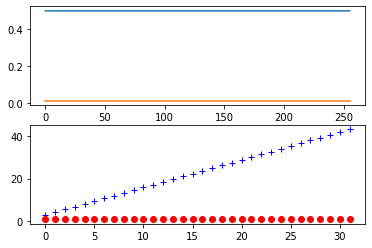

In [131]:
dds = readback_dds()
plt.subplot(211)
plt.plot(np.abs(dds[0::1024]))
plt.plot(np.abs(dds[1::1024]))
plt.subplot(212)
plt.plot(np.unwrap(np.angle(dds[0::1024][0:32])), 'b+')
plt.plot(np.unwrap(np.angle(dds[1::1024][0:32])), 'ro')
plt.show()

16383.998199462792
[-2.8349173  -2.22003503 -1.60510557 -0.99032702 -0.3754171   0.23941239
  0.85429177  1.46917811  2.08400703  2.69891068]
[-2.70033038 -2.08543016 -1.47064786 -0.85572161 -0.24086309  0.37396637
  0.98887108  1.60370048  2.21855777  2.83344998]


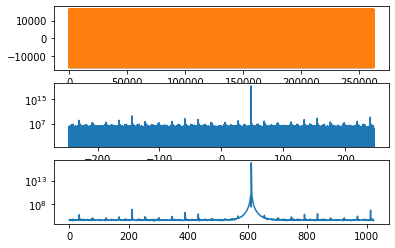

In [132]:
dac = readback_dac()
print(max(np.abs(dac)))
phase = np.angle(dac)
print(phase[0:10])
print(phase[-10:])
plt.subplot(311)
plt.plot(dac.real)
plt.plot(dac.imag)
plt.subplot(312)
dac_spec = np.abs(np.fft.fft(dac))**2
spec_freqs = np.fft.fftfreq(len(dac_spec),1/(ADC_SAMPLE_RATE_MHZ / ADC_DECIMATION))
plt.semilogy(np.fft.fftshift(spec_freqs), np.fft.fftshift(dac_spec))
plt.subplot(313)
p = do_pfb(dac)
plt.semilogy(np.fft.fftshift(p))
plt.show()

# ADC DATA

In [133]:
def get_snap_data(n_points=-1):
  d, t = fpga.snapshots.adc_snapshot.read_raw(man_trig=True)
  v = struct.unpack('>%dh' % (d['length']//2), d['data'])
  vi = np.array(v[0::2], dtype=int)
  vq = np.array(v[1::2], dtype=int)
  if n_points > 0:
    vi = vi[0:n_points]
    vq = vq[0:n_points]
  return vi, vq

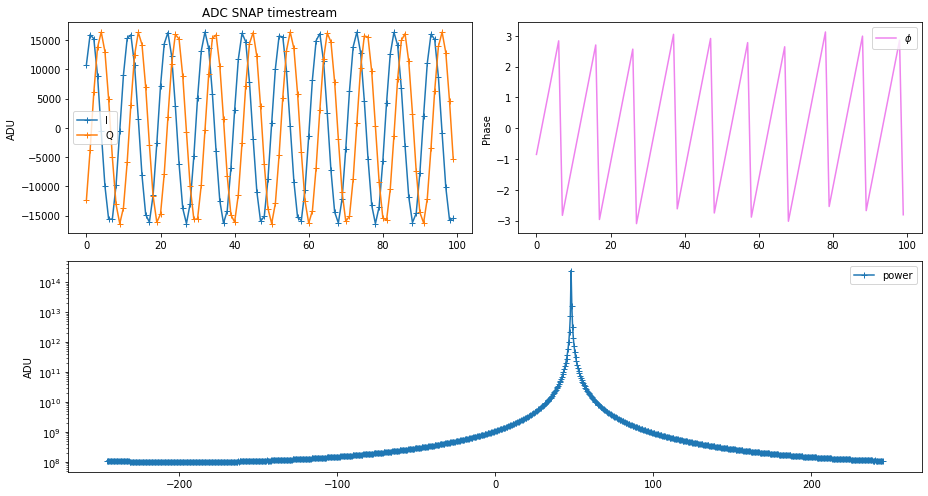

In [134]:
I3, Q3 = get_snap_data(NFFT)

plt.figure(figsize=(13,7))
c = slice(0,100)

plt.subplot(221)
plt.plot(I3[c],"-+",label="I")
plt.plot(Q3[c],"-+",label="Q")
plt.title("ADC SNAP timestream")
plt.ylabel("ADU")
plt.legend()

plt.subplot(222)
plt.plot(np.arctan2(Q3[c],I3[c]),color="violet",label=r'$\phi$')
plt.ylabel("Phase")
plt.legend()

plt.subplot(2,2,(3,4))
spec=np.fft.fft(I3+1j*Q3)
spec_freqs = np.fft.fftfreq(len(I3),1/(ADC_SAMPLE_RATE_MHZ / ADC_DECIMATION))
spec=np.abs(spec) # |spec|
plt.semilogy(np.fft.fftshift(spec_freqs), np.abs(np.fft.fftshift(spec))**2,"-+",label="power")
#plt.semilogy(np.abs(spec)**2,"-+",label="power")

plt.ylabel("ADU")
plt.legend()
plt.tight_layout()
# plt.savefig("ADCsnap.pdf")
plt.show()

## Polyphase Filterbank Snap

In [135]:
# make sure to toggle sync (gpio) first
def get_pfb_data():
    d, t = fpga.snapshots.pfb_snapshot.read_raw()
    v = np.array(struct.unpack('>%dh' % (d['length']//2), d['data']), dtype='int32')
    # Build complex values
    cv = np.zeros(len(v)//2, dtype=complex)
    cv.real = v[0::2]
    cv.imag = v[1::2]
    cv *= 2**2
    return cv

In [175]:
a = fpga.read_uint('fft_of_cnt')
time.sleep(1)
b = fpga.read_uint('fft_of_cnt')
print(b-a)

0


[     0.         125356.47480685   5965.58127931]


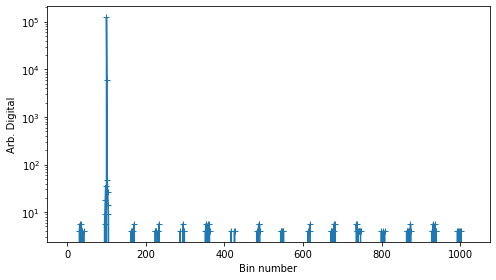

In [201]:
sync()

#SPECpfb = np.fft.fftshift(get_pfb_data()[0:NFFT])
SPECpfb = get_pfb_data()[0:NFFT]

mag = abs(SPECpfb)
print(mag[99:102])

spec_freqs = np.fft.fftfreq(len(SPECpfb),1/(ADC_SAMPLE_RATE_MHZ / ADC_DECIMATION))
plt.figure(figsize=(7,4))
#plt.title(r"$f_s=2048MHZ, N_{bins}=512$"+"(7 tones, external hardware loopback)")
plt.ylabel("Arb. Digital")
#plt.plot(mag)
shift = False
if shift:
    plt.semilogy(np.fft.fftshift(spec_freqs), np.fft.fftshift(mag),"-+",label='PFB mag')
    plt.xlabel("Frequency (MHz)")
else:
    plt.semilogy(mag,"-+",label='PFB mag')
    plt.xlabel("Bin number");

#plt.xlim(0,20)
#plt.plot(Qpfb_f,"-+",label='Q')
#plt.legend()
plt.tight_layout()
#plt.savefig("pfb_snap.pdf")
plt.show()

In [177]:
fpga.read_uint('accum_rst')

0

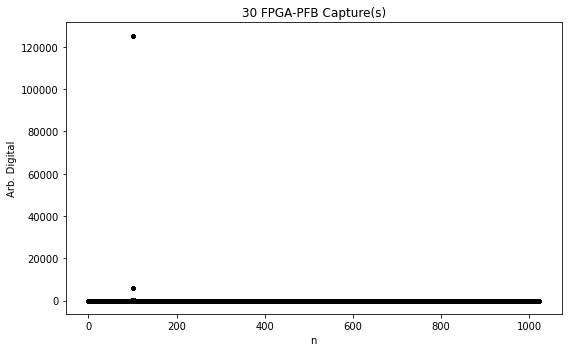

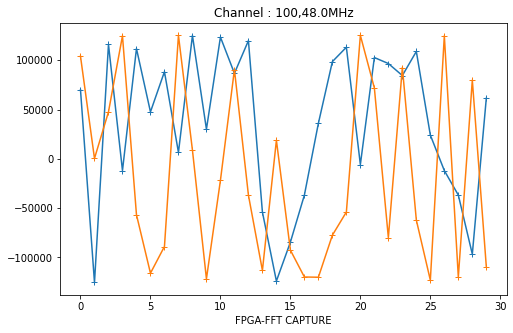

In [178]:
plt.figure(figsize=(8,5))
M=30
k=100
bin_width_mhz = ADC_SAMPLE_RATE_MHZ / ADC_DECIMATION / NFFT
#k+=512
chnl_ts = np.zeros(M,dtype=complex)
plt.title(f"{M} FPGA-PFB Capture(s)")
for i in range(M):
    SPECpfb = get_pfb_data()
    chnl_ts[i] = SPECpfb[k]
    mag = abs(SPECpfb)
    #print(mag[k])
    #plt.title(r"$f_s=2048MHZ, N_{bins}=512$"+"(7 tones, external hardware loopback)")
    plt.xlabel("n"); plt.ylabel("Arb. Digital")
    #plt.plot(mag)
    plt.plot(mag[1024*0:1*1024],".",color="black",alpha=0.5)
    plt.plot(mag[1024*1:2*1024],".",color="black",alpha=0.5)
    plt.plot(mag[1024*2:3*1024],".",color="black",alpha=0.5)
    plt.plot(mag[1024*3:4*1024],".",color="black",alpha=0.5)
    #plt.xlim(0,1024)
    plt.grid()
    plt.tight_layout()
#plt.axvline(1024+k,color="red",alpha=0.2)
plt.show()

plt.figure(figsize=(8,5));plt.title(f"Channel : {k},{(bin_width_mhz*k)}MHz")
plt.plot(chnl_ts.real,"-+")
plt.plot(chnl_ts.imag,"-+")
plt.xlabel("FPGA-FFT CAPTURE")
plt.show()

# Digital Down Conversion

In [139]:
def get_ddc_data():
    d, _ = fpga.snapshots.ddc_snapshot.read_raw()
    v = struct.unpack('>%dh' % (d['length']//2), d['data'])
    # Build complex
    cv = np.zeros(len(v)//2, dtype=complex)
    cv.real = v[0::2]
    cv.imag = v[1::2]
    cv *= 2**3
    return cv



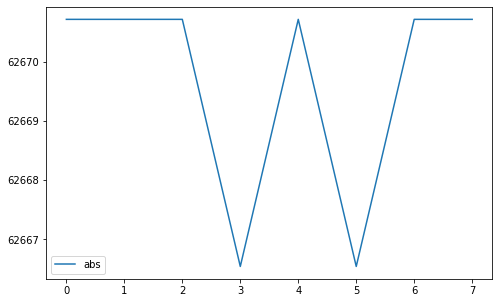

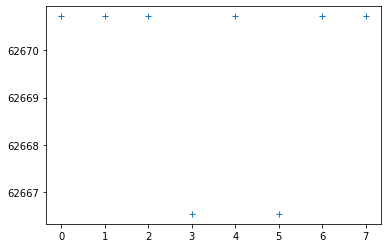

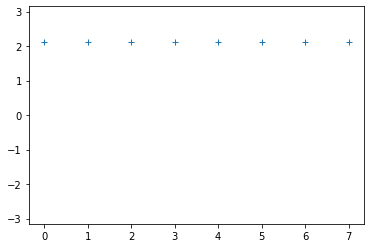

In [202]:
ddc_IQ_dat = get_ddc_data()

ddc = ddc_IQ_dat[0::1024]

plt.figure(figsize=(8,5))

#plt.plot(Iddc_f[50:150],label='I')
#plt.plot(Qddc_f[50:150],label='Q')
plt.plot(np.abs(ddc),label='abs')
#plt.plot(ddc.imag,label='Q')
plt.legend()
plt.show()

plt.figure()
plt.plot(np.abs(ddc),"+")
plt.show()

plt.figure()
plt.plot(np.angle(ddc),"+")
plt.ylim(-3.15, 3.15)
plt.show()

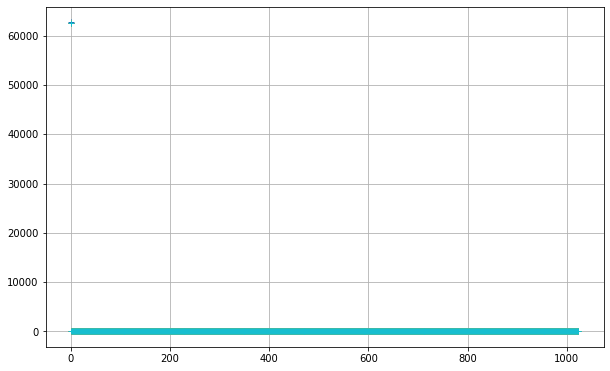

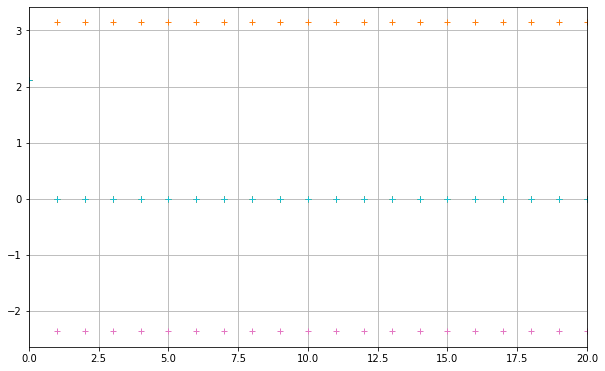

In [203]:
plt.figure(figsize=(1.25*8,1.25*5))

for n in range(50):
    sleep(0.005)
    ddc_IQ_dat = get_ddc_data()

    Iddc_f = ddc_IQ_dat.real[0:1024]
    Qddc_f = ddc_IQ_dat.imag[0:1024]

    plt.plot(abs(Iddc_f+1j*Qddc_f),"+")
    #plt.xlim(210,230)
plt.grid()

plt.figure(figsize=(1.25*8,1.25*5))

for n in range(50):
    sleep(0.005)
    ddc_IQ_dat = get_ddc_data()

    Iddc_f = ddc_IQ_dat.real[0:1024]
    Qddc_f = ddc_IQ_dat.imag[0:1024]

    plt.plot(np.angle(Iddc_f+1j*Qddc_f),"+")
    plt.xlim(0,20)
plt.grid()

plt.show()

## Vector Accumulate and Downsample

In [232]:
def get_accum_data():
    fpga.snapshots.acc_snapshot0.arm() # Arms 0 and 1
    ss0, _ = fpga.snapshots.acc_snapshot0.read_raw(arm=False)
    ss1, _ = fpga.snapshots.acc_snapshot1.read_raw(arm=False)
    v0 = struct.unpack('>%di' % (ss0['length']//4), ss0['data'])
    v1 = struct.unpack('>%di' % (ss1['length']//4), ss1['data'])
    # Build complex
    cv = np.zeros(len(v0), dtype=complex)
    cv[0::2].real = v0[0::2]
    cv[0::2].imag = v0[1::2]
    cv[1::2].real = v1[0::2]
    cv[1::2].imag = v1[1::2]
    return cv

def get_chan0_samples():
    d, _ = fpga.snapshots.acc_chan0_snapshot.read_raw()
    v = struct.unpack('>%di' % (d['length']//4), d['data'])
    cv = np.zeros(len(v)//2, dtype=complex)
    #print(v[0:100])
    cv.real = v[0::2]
    cv.imag = v[1::2]
    #print(cv[0:100])
    return cv

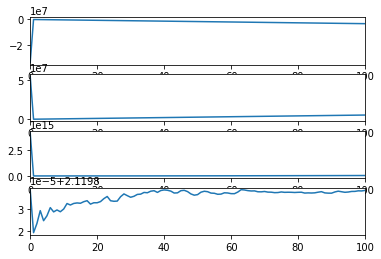

In [233]:
chan0 = get_chan0_samples()
plt.subplot(4,1,1)
plt.plot(np.real(chan0))
plt.xlim(0,100)
plt.subplot(4,1,2)
plt.plot(np.imag(chan0))
plt.xlim(0,100)
plt.subplot(4,1,3)
plt.plot(np.abs(chan0)**2)
plt.xlim(0,100)
plt.subplot(4,1,4)
plt.plot(np.angle(chan0))
plt.xlim(0,100)
plt.show()


In [165]:
fpga.listdev()

['acc_chan0_snapshot_bram',
 'acc_chan0_snapshot_ctrl',
 'acc_chan0_snapshot_status',
 'acc_snapshot0_bram',
 'acc_snapshot0_ctrl',
 'acc_snapshot0_status',
 'acc_snapshot1_bram',
 'acc_snapshot1_ctrl',
 'acc_snapshot1_status',
 'accum_len',
 'accum_rst',
 'adc_dac_loopback',
 'adc_snapshot_bram',
 'adc_snapshot_ctrl',
 'adc_snapshot_status',
 'bins',
 'chan_reorder_eo_choose_0',
 'chan_reorder_eo_choose_1',
 'chan_reorder_reorder0_map1',
 'chan_reorder_reorder1_map1',
 'dac_readback_lsb',
 'dac_readback_msb',
 'dac_wave_i',
 'dac_wave_q',
 'ddc_snapshot_bram',
 'ddc_snapshot_ctrl',
 'ddc_snapshot_status',
 'dds_shift',
 'dds_wave_i',
 'dds_wave_q',
 'fft_of_cnt',
 'fft_shift',
 'load_bins',
 'pfb_snapshot_bram',
 'pfb_snapshot_ctrl',
 'pfb_snapshot_status',
 'rfdc',
 'sync',
 'sys_block',
 'sys_board_id',
 'sys_clkcounter',
 'sys_rev',
 'sys_rev_rcs',
 'sys_scratchpad']

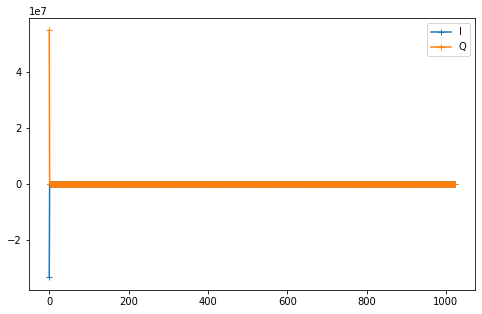

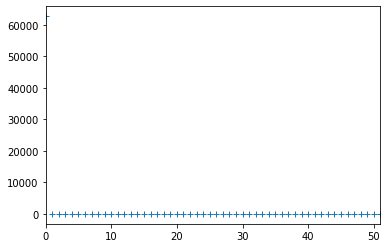

In [230]:
accum_IQ_dat = get_accum_data()
Iacc_f = accum_IQ_dat.real
Qacc_f = accum_IQ_dat.imag
Ia, Qa = np.array(Iacc_f), np.array(Qacc_f)

plt.figure(figsize=(8,5))
plt.plot(Ia[0*1024:1024],"-+",label='I')
plt.plot(Qa[0*1024:1024],"-+",label='Q')
plt.legend()
#plt.xlim(60-10,len(freqs)+60+10)
plt.show()

plt.figure()
IQMAG=np.sqrt(Ia**2+Qa**2)
plt.plot(IQMAG[0*1024:1024]/2**10,"+")
plt.xlim(0,len(freqs)+50)
plt.show()

In [ ]:
D=Ia[0*1024:1024]
for d in D:
    print(f"{int(d):b}")


In [ ]:
plt.figure(figsize=(8,5))
plt.plot(Ia[1024*3:4*1024],"-+",label='I')
plt.plot(Qa[1024*3:4*1024],"-+",label='Q')
plt.xlim(60-10,len(freqs)+60+10)
plt.legend()
#plt.xlim(60-10,len(freqs)+60+10)
plt.show()

plt.figure()
IQMAG=np.sqrt(Ia**2+Qa**2)
#plt.plot(IQMAG[1024*3:4*1024],"+")
plt.plot(IQMAG,"+")
#plt.xlim(60-10,len(freqs)+60+10)
plt.show()

In [ ]:
(IQMAG[60:60+len(freqs)]*1e-4)

In [ ]:
phi

In [ ]:
plt.figure()
for _ in range(5):
    accum_IQ_dat = get_accum_data()
    Iacc_f = accum_IQ_dat.real
    Qacc_f = accum_IQ_dat.imag
    Ia, Qa = np.array(Iacc_f), np.array(Qacc_f)

    IQMAG=np.sqrt(Ia**2+Qa**2)
    plt.plot(IQMAG,"+",color="black",alpha=0.2)
plt.xlim(60-10,60+len(freqs)+10)
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(Ia[0:70],label='I')
plt.plot(Qa[0:70],label='Q')
plt.legend()
#plt.xlim(0,1054)
plt.show()

In [ ]:
Ia[239]

In [ ]:
Is=[]
Qs=[]
xs=[]
for _ in range(150):
    x=get_accum_data()
    I=x.real
    Q=x.imag
    #print(x[150:155])
    Is.append(I)
    Qs.append(Q)
    xs.append(x)

In [ ]:
accum_IQ_dat[0:10]

In [ ]:
# mag_shift = np.zeros(1024)
l=2
for j in range(10):
    print("run {}".format(j))
    print("="*25)
    shiftmax=0
    for i in range(0, 512):
        dds_shift.write(0x00,i)
        sleep(0.75)
        #if i%50 == 0:
        #  print(i)
        accum_IQ_dat = get_accum_data()
        Iacc_f = accum_IQ_dat.real[1024*l:1024*(l+1)].astype("float")
        Qacc_f = accum_IQ_dat.imag[1024*l:1024*(l+1)].astype("float")
        MAG =  np.max(np.sqrt(Iacc_f**2+Qacc_f**2))
        #print(MAG)
        if MAG > shiftmax:
            shiftmax=MAG
            print("shift: {} maxshift: {}".format(i, shiftmax))

In [ ]:
 dds_shift.write(0x00,270) # 451 ,133  233

In [ ]:
(400e6)/900

In [ ]:
#114

# 40-60
# 210-260
# 340 - 400

In [ ]:
def find_res(center=1000,res=30e-3,span=0.512,ntones=1000,centered=False):
    ##############################
    #  Set VALON LO Value        #
    ############################## 
    
    offs=60
    NN=len(freqs)
    c=slice(offs,offs+NN)
    AVGS = 1
    
    source_channel=2
    LO_power = 0 # dBm
    valon=Valon.Synthesizer('/dev/ttyUSB0')
    if not centered:
        dfs=np.linspace(0,span,int(span/res))
    else:
        dfs=np.linspace(-span//2,span//2,int(span/res))
    valon.set_rf_level(source_channel,LO_power)
    
    data=np.zeros(shape=(len(dfs),ntones))
    f=np.zeros(shape=(len(dfs),ntones))
    
    for i,df in enumerate(dfs): 
        f_LO=center+df
        valon.set_frequency(source_channel,f_LO)
        sleep(.05)
        IQmag=np.zeros(NN)
        for _ in range(AVGS):
            accum_IQ_dat = get_accum_data(accum_snap).astype("int32")
            Ia = accum_IQ_dat[0::2].astype("float")
            Qa = accum_IQ_dat[1::2].astype("float")
            IQmag+=np.sqrt(Ia**2+Qa**2)[c]
        IQmag/=AVGS
        data[i]=IQmag
        f[i]=np.flip(freqs+df*1e6)

    valon.set_frequency(source_channel,center)
    return f, data
ff,dd=find_res(center=950,res=.01,span=1.96,ntones=len(freqs))

In [ ]:
ddtestcal=dd.flatten('F') #/ddcal.flatten('F')
# ddtestlog=10*np.log10(ddtest)
plt.figure(figsize=(15,5))
plt.plot(200+1*ff.flatten('F')*1e-6,ddtestcal,"+")
# resonators=np.array([477.5,639,774,889.5])-670